# Welcome to the icet Monte-Carlo tutorial part 1

In this tutorial we will demonstrate how Monte Carlo sampling in various ensembles can be carried out with `icet` and its Monte-Carlo module `mchammer`.

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer
%matplotlib inline

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print('Dont worry')

## Constructing the model
In this tutorial we'll consider a simple toy nearest neighbor model for the a binary (Si Ge) on a simple cubic lattice.

The model is constructed with zerolet ECI $J_0=0.0$ and singlet ECI $J_1=0.0$. The nearest neighbor ECI is $J_2=-0.1$eV


In [2]:
from ase.build import bulk
from icet import ClusterSpace, ClusterExpansion

# parameters
a0 = 3.0
cutoffs = [a0 + 0.1]
chemical_symbols = ['Si', 'Ge']
ising_ecis = [0, 0, -0.1]

# build model
prim = bulk('Si', 'sc', a=a0)
cs = ClusterSpace(prim, cutoffs, chemical_symbols)
ce = ClusterExpansion(cs, ising_ecis)
print(ce)

========================================== Cluster Expansion ===========================================
 space group                            : Pm-3m (221)
 chemical species                       : ['Ge', 'Si'] (sublattice A)
 cutoffs                                : 3.1000
 total number of parameters             : 3
 number of parameters by order          : 0= 1  1= 1  2= 1
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
 total number of nonzero parameters     : 1
 number of nonzero parameters by order  : 0= 0  1= 0  2= 1 
--------------------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multi_component_vector | sublattices |    ECI   
--------------------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     | 

## Testing the model
This nearest neighbor model is a non-mixing model meaning `Si` and `Ge` will phase separate at low temperatures, with a reversed sign of $J_2$ the model would instead be mixing.

To confirm this behavior of the model we enumerate some hundreds of structures (up to supercells containing 8 atoms) and predict their energies

In [3]:
import pandas as pd
from icet.tools.structure_generation import enumerate_structures

sizes = range(1, 8)
records = []
for atoms in enumerate_structures(prim, sizes, chemical_symbols):
    c_Si = atoms.get_chemical_symbols().count('Si') / len(atoms)
    E = ce.predict(atoms)
    row = dict(c_Si=c_Si, E=E)
    records.append(row)
df = pd.DataFrame(records)


Next we visualize the energies.

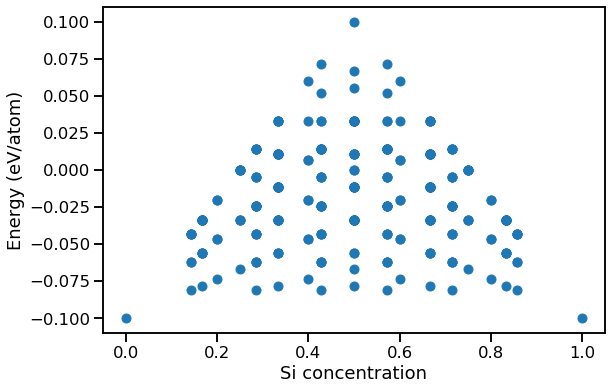

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
plt.figure(figsize=(9, 6))
plt.plot(df.c_Si, df.E, 'o')
plt.xlabel('Si concentration')
plt.ylabel('Energy (eV/atom)');


## Monte Carlo in the canonical ensemble
Next we'll do some thermodynamic sampling in the canonical ensemble. In the canonical ensemble $(N_i, V, T)$ are kept fixed, where i denotes each species in the system.
In a Monte Carlo simulation in the canonical ensemble a trial step consists of swapping the position of two atoms of different species.

Such a swap is associated with a change in energy $\Delta E$ and the swap is accepted with a probability $P = \min \{ 1, \, \exp [ - \Delta E / k_B T  ] \}$.


We'll start with running a simple MC simulation and discover some of the basic features in icet's Monte Carlo module MCHAMMER. First the supercell to be used with a desired concentration has to be setup

In [5]:
import numpy as np

def generate_randomized_supercell(prim, size, c_Si):
    supercell = prim.repeat(size)
    N = len(supercell)
    n_Si = int(c_Si * N)
    symbols = ['Si'] * n_Si + ['Ge'] * (N-n_Si)
    np.random.shuffle(symbols) 
    supercell.set_chemical_symbols(symbols)
    return supercell

Next we setup a Monte Carlo calculator which is based on the ClusterExpansion but is supercell specific. This allows the calculator to precompute a lot of supercell-related quantities which thus makes it very fast for MC simulations. This allows for the MC simulation to be run.

In [6]:
from mchammer.ensembles import CanonicalEnsemble   
from mchammer.calculators import ClusterExpansionCalculator


# MC parameters
size = 4
T = 1500
n_steps = 10000

# run MC
supercell = generate_randomized_supercell(prim, size, 0.5)
calc = ClusterExpansionCalculator(supercell, ce)
mc = CanonicalEnsemble(supercell, calc, T)
mc.run(n_steps)


The results from the MC is stored in a `DataContainer` object. This has a lot of utility functions for accessing the results from the MC simulation. Next we'll plot some results from this initial simulation

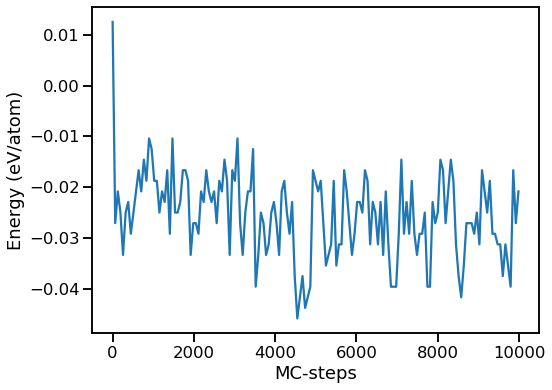

In [7]:
# get data
dc = mc.data_container
steps, energies = dc.get('mctrial', 'potential')
energies /= len(supercell)

# plot
fig = plt.figure(figsize=(8, 6))
plt.plot(steps, energies)
plt.xlabel('MC-steps')
plt.ylabel('Energy (eV/atom)');

The trajectory of the simulation can be viewed with some help from ASE. The trajectory shows that `Si` and `Ge` are clearly phase separating.

In [8]:
from ase.visualize import view

traj = dc.get('trajectory')
view(traj)

### Observers
Observers are objects that you can attach to your MC object and will record a property every so often from your MC simulation. Pre-defined observers available in `mchammer` are `BinaryShortRangeOrderObserver`, `SiteOccupancyObserver`   and `ClusterCountObserver`. 

To study the ordering phenomena for our Si-Ge system we'll employ a short range order (SRO) observer which implements the Warren Cowley order parameter, defined as

\begin{equation}
\text{sro} = 1 - \frac{n_{AB}}{c_A n_{tot}}
\end{equation}
where $n_{AB}$ is the number of nearest neighbor pairs, $n_{tot}$ is the total number of nearest neighbor pairs and $c_A$ the concentration of species A. In a random mixture you would expected $n_{AB} = c_A n_{tot}$ and thus a short range order of 0. If the A and B phase separate such that there are no AB pairs then a high SRO is obtained.

In [9]:
from mchammer.observers import BinaryShortRangeOrderObserver

### Critical temperature
One way of studying critical temperature and phase transitions is to carry out multiple MC simulations in the canonical ensemble. This allows the energy, heat capacity and SRO to be analyzed for various temperatures. Phase transitions often give rise to rapid changes in these properties as a function temperature.

Storing datacontainers to file is often preferable. This can simply be achieved by specifying an filename to Ensemble (see below). This also allows the MC-simulation to be restarted.


In [10]:
# parameters
size = 4
c_Si = 0.5
temperatures = np.arange(1800, 400, -100)
n_steps = 20000

atoms = generate_randomized_supercell(prim, size, c_Si)
for T in temperatures:
    print('Running MC at {}K'.format(T))
    
    dc_fname = 'canonical_runs/dc_size{}_T{}.dc'.format(size, T)
    
    sro_obs = BinaryShortRangeOrderObserver(cs, atoms, interval=len(atoms), radius=3.1)
    calc = ClusterExpansionCalculator(atoms, ce)
    mc = CanonicalEnsemble(atoms, calc, T, dc_filename=dc_fname)
    mc.attach_observer(sro_obs)
    
    mc.run(n_steps)
    atoms = mc.structure
    

Running MC at 1800K
Running MC at 1700K
Running MC at 1600K
Running MC at 1500K
Running MC at 1400K
Running MC at 1300K
Running MC at 1200K
Running MC at 1100K
Running MC at 1000K
Running MC at 900K
Running MC at 800K
Running MC at 700K
Running MC at 600K
Running MC at 500K


Note that a system of 64 and 20,000 trial steps are both quite small. In the second part of this tutorial fully converged datacontainers for a 12x12x12 supercell are provided to save time.

The resulting data containers from the shorter MC-simulations above can now be collected and analyzed.

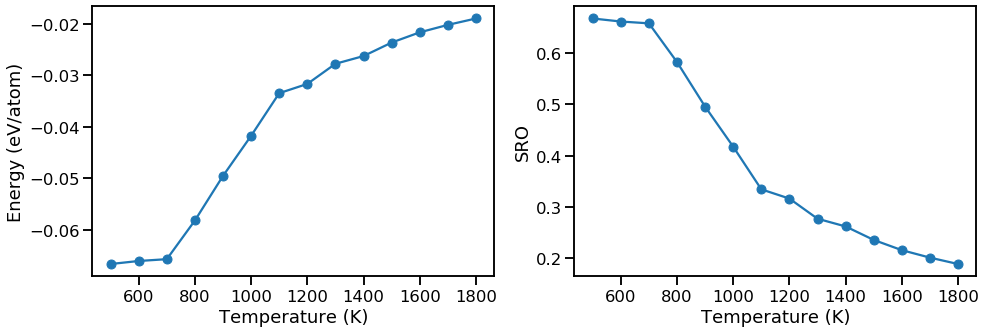

In [11]:
import glob
from mchammer import DataContainer


# collect data
eq_steps = 500

dc_fnames = glob.glob('canonical_runs/dc_size{}*.dc'.format(size))
records = []
for fname in dc_fnames:
    dc = DataContainer.read(fname)
    
    T = dc.ensemble_parameters['temperature']
    N = dc.ensemble_parameters['n_atoms']
    E = dc.get('potential', start=eq_steps) / N
    sro = dc.get('sro_Ge_1', start=eq_steps)
    
    row = dict(temperature=T, energy=E.mean(), sro=sro.mean())
    records.append(row)
    
df = pd.DataFrame(records)
df = df.sort_values(by='temperature')


# plotting
fig = plt.figure(figsize=(14, 9))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(df.temperature, df.energy, '-o')
ax2.plot(df.temperature, df.sro, '-o')

ax1.set_xlabel('Temperature (K)')
ax2.set_xlabel('Temperature (K)')

ax1.set_ylabel('Energy (eV/atom)')
ax2.set_ylabel('SRO')

fig.tight_layout()


The resulting thermodynamic properties indicate a phase transition. For a more accurate analysis see the next tutorial.

## Semi Grand Canonical Ensemble
Next we'll do some thermodynamic sampling in the semi grand canonical ensemble. In this ensemble $(\mu_i, V, T)$ are kept fixed, where $\mu_i$ denotes each species in the system.
In a Monte Carlo simulation in the semi-grand canonical ensemble a trial step consists of flipping an atom from one species to another.

Such a flip is associated with a change in energy $\Delta E$ as well as a change in number of atoms of each species. The flip is accepted with probability $P = \min \Big\{ 1, \, \exp \big[ - \big( \Delta E + \sum_i \Delta \mu_i \Delta N_i \big) \big / k_B T \big] \Big\}$.


We'll start by running a short test MC-simulation.

In [12]:
from mchammer.ensembles import SemiGrandCanonicalEnsemble   

# MC parameters
size = 6
T = 1500
n_steps = 20000
chemical_potentials = dict(Si=0.01, Ge=0.0) # in eV

# run MC
supercell = generate_randomized_supercell(prim, size, 0.5)
calc = ClusterExpansionCalculator(supercell, ce)
mc = SemiGrandCanonicalEnsemble(supercell, calc, T, chemical_potentials)
mc.run(n_steps)

In the SGC ensemble the concentration is not fixed but is an important thermodynamic property. These are automatically added to DataContainer as seen below.

Available obserables ['potential', 'acceptance_ratio', 'Si_count', 'Ge_count', 'occupations']


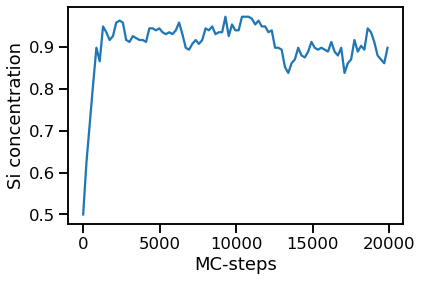

In [13]:
# check the available observers
print('Available obserables', mc.data_container.observables)

# plot Si concentration
steps, Si_counts = mc.data_container.get('mctrial', 'Si_count')
c_Si = Si_counts / len(supercell)
plt.plot(steps, c_Si)
plt.xlabel('MC-steps')
plt.ylabel('Si concentration');

### Miscibility gap
By running multiple SGC simulations the $\mu_{Si}$ - $\left < c_{Si} \right >$ relation can be mapped out. If there exists a miscibility gap there will be a sudden jump in concentration when varying the chemical potential.

Next we'll explore this effect. (Fully converged datacontainers can be found in the next part of this tutorial)

In [14]:
# MC parameters
size = 6
T = 1500
n_steps = 20000
mu_vals = np.round(np.linspace(-0.03, 0.03, 21), 6)

# run MC
atoms = generate_randomized_supercell(prim, size, 0.5)
for mu_Si in mu_vals:
    print('Running SGC for mu_Si {}'.format(mu_Si))
    dc_fname = 'sgc_runs/dc_size{}_T{}_muSi{}.dc'.format(size, T, mu_Si)

    chemical_potentials = dict(Si=mu_Si, Ge=0.0)
    calc = ClusterExpansionCalculator(supercell, ce)
    mc = SemiGrandCanonicalEnsemble(supercell, calc, T, chemical_potentials, dc_filename=dc_fname)
    
    mc.run(n_steps)
    atoms = mc.structure

Running SGC for mu_Si -0.03
Running SGC for mu_Si -0.027
Running SGC for mu_Si -0.024
Running SGC for mu_Si -0.021
Running SGC for mu_Si -0.018
Running SGC for mu_Si -0.015
Running SGC for mu_Si -0.012
Running SGC for mu_Si -0.009
Running SGC for mu_Si -0.006
Running SGC for mu_Si -0.003
Running SGC for mu_Si 0.0
Running SGC for mu_Si 0.003
Running SGC for mu_Si 0.006
Running SGC for mu_Si 0.009
Running SGC for mu_Si 0.012
Running SGC for mu_Si 0.015
Running SGC for mu_Si 0.018
Running SGC for mu_Si 0.021
Running SGC for mu_Si 0.024
Running SGC for mu_Si 0.027
Running SGC for mu_Si 0.03


Now we collect and plot $\mu_{Si}$ - $\left < c_{Si} \right >$.

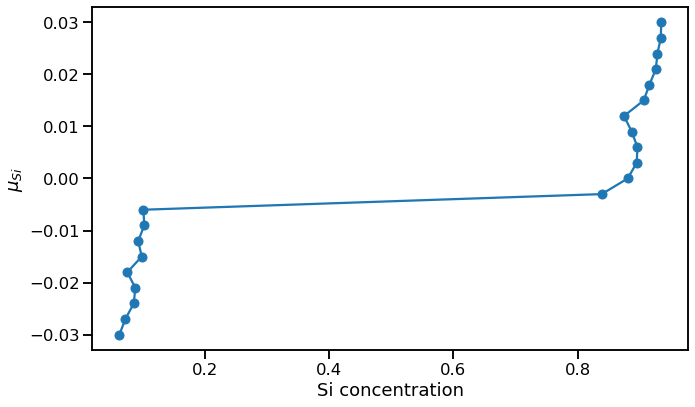

In [15]:
import glob
from mchammer import DataContainer


# collect data
size = 6
eq_steps = 500

dc_fnames = glob.glob('sgc_runs/dc_size{}*.dc'.format(size))
records = []
for fname in dc_fnames:
    dc = DataContainer.read(fname)
    
    N = dc.ensemble_parameters['n_atoms']
    mu_Si = dc.ensemble_parameters['mu_Si']
    E = dc.get('potential', start=eq_steps) / N
    c_Si = dc.get('Si_count') / N
    
    row = dict(mu_Si=mu_Si, energy=E.mean(), sro=sro.mean(), c_Si=c_Si.mean())
    records.append(row)
    
df = pd.DataFrame(records)
df = df.sort_values(by='mu_Si')


# plotting
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

ax1.plot(df.c_Si, df.mu_Si, '-o')
ax1.set_xlabel('Si concentration')
ax1.set_ylabel(r'$\mu_{Si}$')

fig.tight_layout()

## Additional Ensembles
There exist more advanced ensembles in mchammer. For example the variance constrained semi grand canonical ensemble allows for sampling inside the miscibility gap [1].

Most of the Monte-Carlo related code is written in python and the local energy calculation is carried out in C++. This allows users to easily modify existing or write their own ensembles in python while maintaining good performance.


[1] Sadigh, B., & Erhart, P. (2012). Calculation of excess free energies of precipitates via direct thermodynamic integration across phase boundaries. Physical Review B, 86(13). https://doi.org/10.1103/physrevb.86.134204 